<a href="https://colab.research.google.com/github/sgmurphy00/TOOLS1/blob/google_collab_environment/ART_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Author: Paul Scheidt
# Description: Implement simple Machine Learning Classification Model for SAT6 Database
# Implement ART toolbox to perform poisoning attack


# Compare pixel distributions of typical classes, then compare pixel distributions of adversarial data
# Array statistics


In [2]:
# Problem Definition


In [3]:
# Real-World Impact

In [4]:
# Dataset Description

Quality of Data and Preprocessing

In [5]:
# Required Python Libraries
from google.colab import drive
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import time

# Libraries for CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from keras.layers import Dropout, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

# Libraries for Visualizing Deeplearning Models
from IPython import display
from tensorflow.keras.utils import plot_model
%matplotlib inline

In [6]:
# Initializing data, developing train/test splits
# Connecting to Deep Stat Database
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
DATA_PATH = '/content/drive/My Drive/DEEPSAT6/'
# Initializing training and valiadation Data Paths
train_data_path = DATA_PATH + '/X_train_sat6.csv'
train_label_path = DATA_PATH + 'y_train_sat6.csv'
test_data_path = DATA_PATH + 'X_test_sat6.csv'
test_label_path = DATA_PATH + 'y_test_sat6.csv'

# Storing data into pandas dataframes
x_train = pd.read_csv(train_data_path, header=None, dtype='uint8')
y_train = pd.read_csv(train_label_path, header=None, dtype='uint8')
x_test = pd.read_csv(test_data_path, header=None, dtype='uint8')
y_test = pd.read_csv(test_label_path, header=None, dtype='uint8')

# Investigating Shape of Pandas DataFrame
print("Train data shape: ", x_train.shape)
print("Train label shape: ", y_train.shape)
print("Test data shape: ", x_test.shape)
print("Test label shape: ", y_test.shape)

Train data shape:  (324000, 3136)
Train label shape:  (324000, 6)
Test data shape:  (81000, 3136)
Test label shape:  (81000, 6)


In [8]:
# Restructuring Training and Test Images to be 3 layers, RGB
x_train = x_train.values.reshape([-1,28,28,4])
x_test = x_test.values.reshape([-1,28,28,4])

x_train.shape, x_test.shape

((324000, 28, 28, 4), (81000, 28, 28, 4))

Text(0.5, 1.0, '0    0\n1    0\n2    0\n3    0\n4    0\n5    1\nName: 3, dtype: uint8')

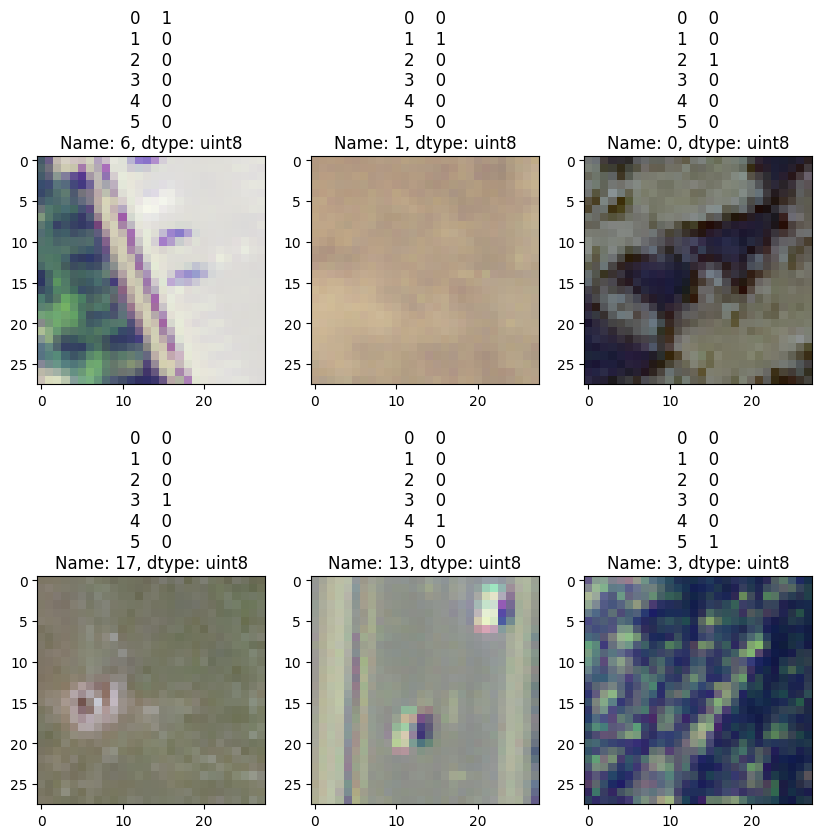

In [9]:
# This Code Block Highlights examples of images from each class


fig = plt.figure(figsize = (10,10))
rows = 2
cols = 3


# plotting Class A
ax1 = fig.add_subplot(rows, cols, 1)
img_A = x_train[6].reshape([28,28,4])[:,:,:3]
label_A = y_train.iloc[6]
plt.imshow(img_A)
ax1.set_title(label_A)

# Plotting Class B
ax2 = fig.add_subplot(rows, cols, 2)
img_B = x_train[1].reshape([28,28,4])[:,:,:3]
label_B = y_train.iloc[1]
plt.imshow(img_B)
ax2.set_title(label_B)

# plotting Class C
ax3 = fig.add_subplot(rows, cols, 3)
img_C = x_train[0].reshape([28,28,4])[:,:,:3]
label_C = y_train.iloc[0]
plt.imshow(img_C)
ax3.set_title(label_C)

# Plotting Class D
ax4 = fig.add_subplot(rows, cols, 4)
img_D = x_train[17].reshape([28,28,4])[:,:,:3]
label_D = y_train.iloc[17]
plt.imshow(img_D)
ax4.set_title(label_D)

# plotting Class E
ax5 = fig.add_subplot(rows, cols,5)
img_E = x_train[13].reshape([28,28,4])[:,:,:3]
label_E = y_train.iloc[13]
plt.imshow(img_E)
ax5.set_title(label_E)

# Plotting Class F
ax6 = fig.add_subplot(rows, cols, 6)
img_F = x_train[3].reshape([28,28,4])[:,:,:3]
label_F = y_train.iloc[3]
plt.imshow(img_F)
ax6.set_title(label_F)

In [10]:
# Insert Exploritory EDA

# Add class distribution
# Work to get a limited sample of adversarial samples

In [11]:
# Loading Pretrained Image Model

In [12]:
def create_modelv1(class_count, print_summary=False):
# Implementing Multi-Class, Classifier CNN in Tensor Flow
# Description: Implement traditional model, highlight model architecture, train and evaluate model performance

    input = tf.keras.Input(shape=(28,28,4))
    x = layers.Conv2D(filters=32,kernel_size=4,activation='relu')(input)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x= layers.Conv2D(filters=64,kernel_size=4,activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.GlobalAveragePooling2D()(x)   # Need Global average Pooling in order to visuals CAMs
    x = layers.Dense(128,activation='relu')(x)
    output = layers.Dense(class_count,activation='softmax')(x)

    model = tf.keras.Model(inputs=input,outputs=output)


    model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

    if print_summary:
        model.summary()
        # Displaying CNN Model
        plt.figure(figsize=(10, 10))
        plot_model(model, show_shapes=True, show_layer_names=True, dpi=100)
    return model

In [18]:

def create_discriminator(class_count, print_summary=False):
  image_size = (28,28)


  input = tf.keras.Input(shape=(28,28,4))
  x = layers.Conv2D(28, 4, strides=(2, 2), padding='same',input_shape=image_size+(1,))(input)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)
  x = layers.Conv2D(4*2, 4, strides=(2, 2), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)
  x = layers.Conv2D(4*4, 4, strides=(2, 2), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)
  x = x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(128,activation='relu')(x)
  class_output = tf.keras.layers.Dense(class_count,activation='softmax')(x)

  model= keras.Model(input, class_output)

  model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if print_summary:
    model.summary()
    # Displaying CNN Model
    plt.figure(figsize=(10, 10))
    plot_model(model, show_shapes=True, show_layer_names=True, dpi=100)
  return model





In [14]:
# Compiling Modelv1

modelv1 = create_modelv1(6)


history_baseline_modelv1 = modelv1.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test,y_test))


Epoch 1/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9190 - loss: 0.4154 - val_accuracy: 0.9703 - val_loss: 0.0790
Epoch 2/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.9634 - loss: 0.0997 - val_accuracy: 0.9772 - val_loss: 0.0678
Epoch 3/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9712 - loss: 0.0795 - val_accuracy: 0.9767 - val_loss: 0.0634
Epoch 4/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9762 - loss: 0.0671 - val_accuracy: 0.9811 - val_loss: 0.0573
Epoch 5/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9779 - loss: 0.0643 - val_accuracy: 0.9765 - val_loss: 0.0632
Epoch 6/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9802 - loss: 0.0558 - val_accuracy: 0.9818 - val_loss: 0.0516
Epoch 7/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9812 - loss: 0.0531 - val_accuracy: 0.9796 - val_loss: 0.0539
Epoch 8/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9826 - loss: 0

In [19]:
model_discriminator = create_discriminator(6)

history_model_discriminator = model_discriminator.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test,y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9422 - loss: 0.1735 - val_accuracy: 0.8808 - val_loss: 0.3352
Epoch 2/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9773 - loss: 0.0640 - val_accuracy: 0.9252 - val_loss: 0.1955
Epoch 3/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9824 - loss: 0.0501 - val_accuracy: 0.9830 - val_loss: 0.0468
Epoch 4/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9849 - loss: 0.0431 - val_accuracy: 0.9518 - val_loss: 0.1537
Epoch 5/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9859 - loss: 0.0402 - val_accuracy: 0.9501 - val_loss: 0.1416
Epoch 6/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9875 - loss: 0.0357 - val_accuracy: 0.9815 - val_loss: 0.0473
Epoch 7/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9885 - loss: 0.0333 - val_accuracy: 0.9810 - val_loss: 0.0499
Epoch 8/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9891 - loss: 0

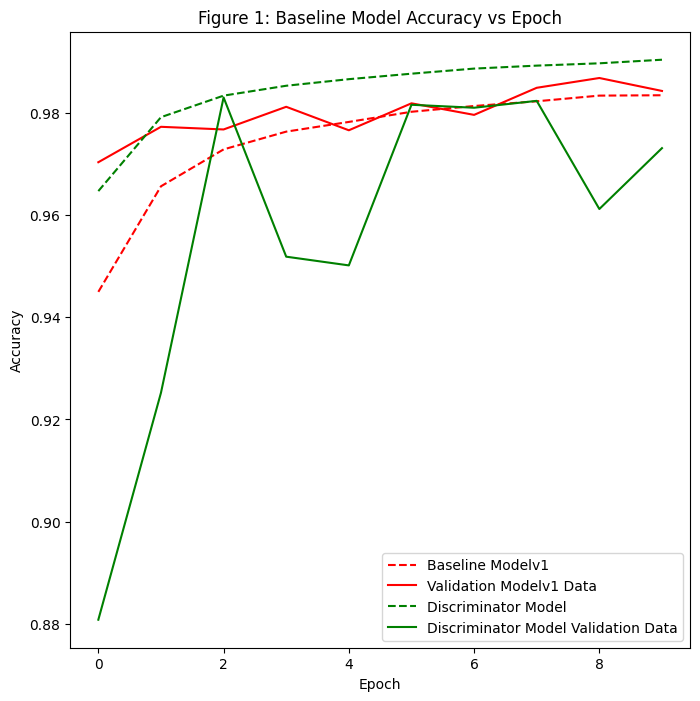

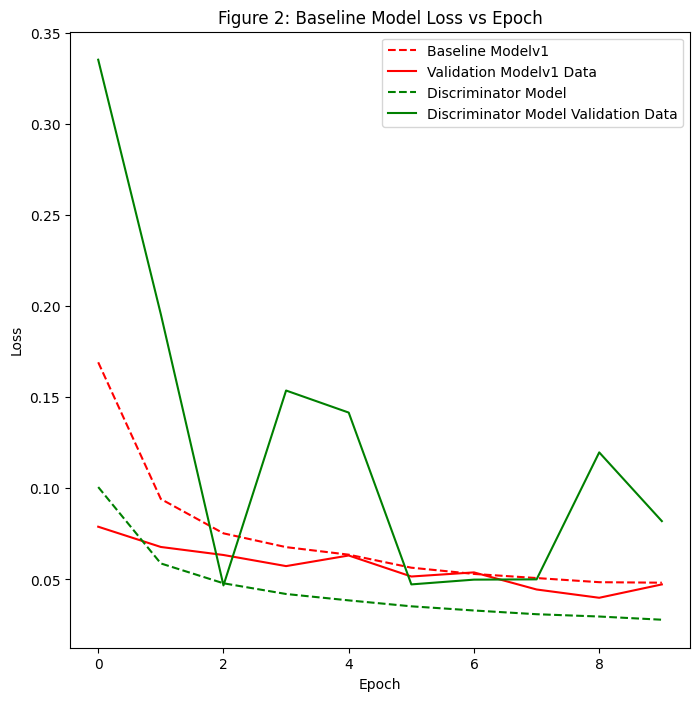

In [21]:
accuracy = plt.figure(figsize =(8, 8))

plt.plot(history_baseline_modelv1.history['accuracy'],'r--',label='Baseline Modelv1')
plt.plot(history_baseline_modelv1.history['val_accuracy'],'r',label='Validation Modelv1 Data')
plt.plot(history_model_discriminator.history['accuracy'],'g--',label='Discriminator Model')
plt.plot(history_model_discriminator.history['val_accuracy'],'g',label='Discriminator Model Validation Data')
plt.title('Figure 1: Baseline Model Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

loss = plt.figure(figsize =(8, 8))
plt.plot(history_baseline_modelv1.history['loss'],'r--',label='Baseline Modelv1')
plt.plot(history_baseline_modelv1.history['val_loss'],'r',label='Validation Modelv1 Data')
plt.plot(history_model_discriminator.history['loss'],'g--',label='Discriminator Model')
plt.plot(history_model_discriminator.history['val_loss'],'g',label='Discriminator Model Validation Data')
plt.title('Figure 2: Baseline Model Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Implementing ART-Toolbox, Data Poisoning